# Exploratory Data Analysis
--------------------------------

## IEEE-CIS Fraud Detection
## 2019-10-21
## TheNerdyCat

Add intro here

## Packages and Data Load

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]
import seaborn as sns
import os

import time
import datetime

In [8]:
input_folder_path = '../input/ieee-fraud-detection/'

time_start = time.time() 
train_identity = pd.read_csv(f'{input_folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{input_folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{input_folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{input_folder_path}test_transaction.csv')
sub = pd.read_csv(f'{input_folder_path}sample_submission.csv')
time_elapsed = time.time() - time_start

# Combine both train and test for ease of data manipulation
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

## Data Overview

In [33]:
print(f'Data import time elapsed: {time_elapsed}')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Data import time elapsed: 0
Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


So there are a reasonable amount of rows but a lot of columns...
Also our test set is almost the same size as our train set

In [14]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [15]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Seperate identity and transaction datasets no longer needed
del train_identity, train_transaction, test_identity, test_transaction

In [21]:
nan_cols_train = train.isnull().any().sum()
print(f'{nan_cols_train} columns in train dataset with missing values.')

414 columns in train dataset with missing values.


## EDA

Our features for our train dataset is organised as follows:
 - `TransactionID`; The ID for each transaction.
 - `isFraud`; Our label for fraudulent transactions.
 - `TransactionDT`; Timedelta from a defined datetime.
 - `TransactionAmt`; The transaction amount.
 - `ProductCD`; 
 - `card1` - `card6`; 
 - `addr1`, `addr2`; 
 - `dist1`, `dist2`; 
 - `P_emaildomain`, `R_emaildomain`; 
 - `C1` - `C14`; 
 - `D1` - `D15`; 
 - `M1` - `M9`; 
 - `V1` - `V339`; 
 - `id_01` - `id_38`; 

### TransactionID

### isFraud

In [68]:
print('{:.2f}% of transactions are fraud in train set.'.format(train['isFraud'].mean() * 100))

3.50% of transactions are fraud in train set.


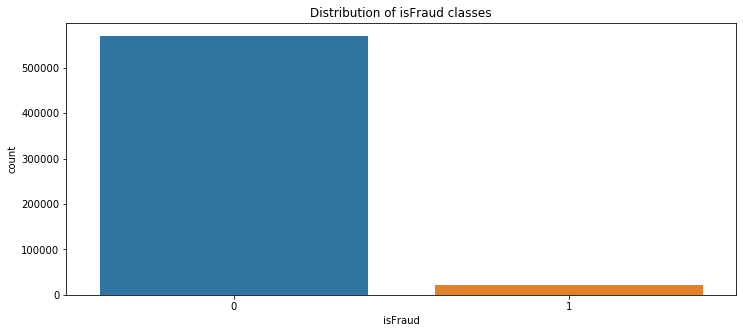

In [75]:
sns.countplot(train.isFraud)
plt.title('Distribution of isFraud classes')
plt.show()

### TransactionDT

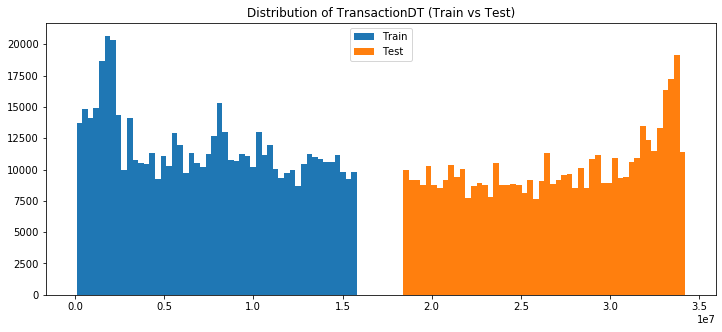

In [56]:
plt.hist(train['TransactionDT'], label='Train', bins=50)
plt.hist(test['TransactionDT'], label='Test', bins=50)
plt.legend()
plt.title('Distribution of TransactionDT (Train vs Test)')
plt.show()

The train and test set do not overlap in time (train is earlier than test), with a small gap in between. This is important to note as it will affect our choice of cross validation techniques. There are slightly higher distributions at both ends of the time period.

### TransactionAmt

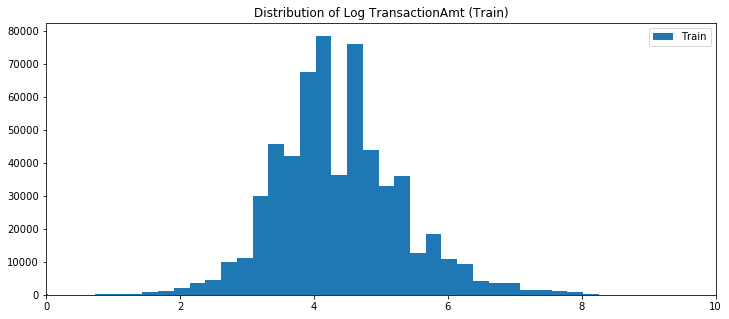

In [96]:
plt.hist(train['TransactionAmt'].apply(np.log), label='Train', bins=50)
plt.xlim(0,10)
plt.legend()
plt.title('Distribution of Log TransactionAmt (Train)')
plt.show()

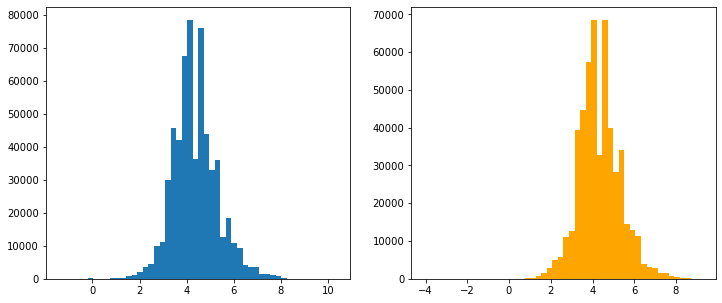

In [132]:
fig, axs = plt.subplots(1,2)

axs[0].hist(train['TransactionAmt'].apply(np.log), label='Train', bins=50)
#plt.xlim(0,10)
#plt.legend()
#plt.title('Distribution of Log TransactionAmt (Train)')

axs[1].hist(test['TransactionAmt'].apply(np.log), label='Test', bins=50, color='orange')
#plt.xlim(0,10)
#plt.legend()
#plt.title('Distribution of Log TransactionAmt (Test)')
plt.show()